# 3MD4120: Reinforcement Learning Individial Assignment

## A Flappy Agent

Karim EL HAGE <br>
karim.elhage@student-cs.fr

## Library Import and Environment Load

In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/50/1fvjcy7x36jg226544f__l_m0000gn/T/pip-req-build-l6l4hu19
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/50/1fvjcy7x36jg226544f__l_m0000gn/T/pip-req-build-l6l4hu19
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


In [8]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import agent
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d

import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

In [170]:
#Load Environment

if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-4)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[     

The observation from the TextFlappyBird-v0 environment consists of the x and y distance from the next pipe as a tuple, which serves as the state agent. Considering the tuple format of the state and different possible combinations of states, it is more interesting to store each unique state in a dictionary with the tuple as the key and the index of the unique state as the value.  Two actions can be sampled from this environment 1 – flap, 0 – remain idle. The agent receives a reward of 1 at every time step. Hence, the goal in this context would be to maximize the reward. The game is over if the agent crashes into the pipe, flaps too high, or drops to the ground. The environment also outputs information such as the score of the agent (increments each time the agent passes through a pip), the position of the agent on the screen, and the resultant distance of the agent from the pipe. By having the agent leverage the agent’s distance from the pipe knowing that they would be rewarded for staying alive at each time step, it is possible to implement a reinforcement learning technique to train an agent to play the game

## Agent Definition

In [10]:
class FlappyQAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info['eps_start']
        self.eps_decay = agent_init_info['eps_decay'] #Amount of decay per episode
        self.eps_min = agent_init_info['eps_min'] #The maximum amount that epsilon could decay to
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        
        #Since states are a tuple of x,y, we need to map the states to an index to keep track of the number
        #of the different possible states. This index will be used rather than the state itself
        #the q function
        self.state_dict = {}
        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        #Decays epislon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)
        
        #store the tuple of dx and dy as the key and generates in index for the pair that can be used to access q
        #generates a new index of the tuple pair does nto exist in the dictionary
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]  
        
        # Choose action using epsilon greedy.
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        #store the tuple of dx and dy as the key and generates in index for the pair that can be used to access q
        #generates a new index of the tuple pair does nto exist in the dictionary
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]   

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        #Refer to Equation (6.8) Section 6.5 page 131 of Sutton and Barto second edn Reinforcemenr Learning
        self.q[self.prev_state_idx, self.prev_action] = self.q[self.prev_state_idx,self.prev_action] \
                                                   + self.step_size*(reward + self.discount*np.max(self.q[state_idx, :]) \
                                                  - self.q[self.prev_state_idx,self.prev_action])

        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        #Since this is terminal state, there is not more any discounter future values
        self.q[self.prev_state_idx, self.prev_action] = self.q[self.prev_state_idx,self.prev_action] + self.step_size*(reward - self.q[self.prev_state_idx,self.prev_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []
        # print(len(q_values))
        for i in range(len(q_values)):
            # print(q_values[i])
            # break
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [11]:
class FlappyESAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info['eps_start']
        self.eps_decay = agent_init_info['eps_decay'] #Amount of decay per episode
        self.eps_min = agent_init_info['eps_min'] #The maximum amount that epsilon could decay to
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        
        #Since states are a tuple of x,y, we need to map the states to an index to keep track of the number
        #of the different possible states. This index will be used rather than the state itself
        #the q function
        self.state_dict = {}
        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        #Decays epislon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min) 
        
        #store the tuple of dx and dy as the key and generates in index for the pair that can be used to access q
        #generates a new index of the tuple pair does nto exist in the dictionary        
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]
        
        # Choose action using epsilon greedy.
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state_idx = state_idx
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        #store the tuple of dx and dy as the key and generates in index for the pair that can be used to access q
        #generates a new index of the tuple pair does not exist in the dictionary
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        #Refer to equation (6.9) in Section 6.6 page 133 of Sutton & Barto second Edn Reinforcement Learning
        
        expected_q = 0
        q_max = np.max(current_q) # get the max q value to assign greedy probability

        epsilon_prob = np.ones(self.num_actions) * self.epsilon / self.num_actions # for all actions by mean
        greedy_prob = (current_q == q_max) * (1 - self.epsilon) / np.sum(current_q == q_max)
        
        pi = epsilon_prob + greedy_prob # pi is the sum of epsilon probility per action plus greedy probability per max actions
        expected_q = np.sum(pi * current_q) # expected values
            
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * expected_q - 
                                                                       self.q[self.prev_state, self.prev_action])
  
        self.prev_state_idx = state_idx
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        #Since it is the terminal state we do not anymore discount future q's
        self.q[self.prev_state_idx, self.prev_action] += self.step_size * (reward - self.q[self.prev_state_idx, self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [12]:
#Funtion to train agent
def train_agent(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma,algorithm = None):
    
    assert algorithm in ['QL','ES']

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # get number of states and actions from environment
    n_states = env.observation_space[0].n * env.observation_space[1].n 
    n_actions = env.action_space.n
    
    agent_info = {"num_actions": n_actions,"num_states":n_states,"eps_start":eps_start,"step_size":step_size,
                  "eps_decay": eps_decay,"eps_min": eps_min,"discount": gamma,"seed": 0}
    
    #Both agents can be trained in the environment
    if algorithm == 'QL':
      agent = FlappyQAgent()
      
    else:
      agent = FlappyESAgent()
    
    #Input agent info
    agent.agent_init(agent_info)
    
    #To store the scores and rewards per episodes
    scores_history = []
    total_reward_history = []
    
    for _ in tqdm(range(num_episodes)):
      state = env.reset() #reset environment each episode
      state = state[0] #observation during reset of the environment consists a tuple of (dx,dy) from the pipe
                    #as well as the the additional info, since we are only interested in the tuple, we only
                    #take the first index as the state to choose the action

      action = agent.agent_start(state)
      reward = 0 #initialize reward
      total_reward = 0 #initialize cumul reward
      while True:
        action = agent.agent_step(reward, state)
        next_state, reward, done,_, info = env.step(action) #the stepped environment outputs the next state 
                                                            #as the tuple (dx,dy), the reward from the action
                                                            # whether the agent has died, an additional boolean
                                                            #that does not seem to be pertinent, and the info
                                                            #from the game such as the score and position of the agent
                                                            #on the screen.
        total_reward += reward 
        state = next_state

        
        if done:
          agent.agent_end(reward) 
          scores_history.append(info['score']) #append the score at the end of the episode

          total_reward_history.append(total_reward) #append the cumul reward at the end of the episode
          break
        
        #Since the agent could theoretically run forever, a max score is added as a second condition to force
        #the agent to die if achieveing the max score
        if info['score'] >= max_score:
          scores_history.append(info['score'])
          total_reward_history.append(total_reward)
          break

    return agent, scores_history,total_reward_history

## Hyper Parameter Tuning

The agent shall only be trained on pairs of step size and epsilon start to be abe to make comparisons between both agent and keep the comparison controlled.

In [ ]:
#Agent 1 Q-Learning Hyperparameter Tuning
params = {"alpha": [0.01, 0.1, 0.2, 0.4, 0.8, 1.0], "eps_start": [0.1, 0.5, 0.99]}
QL_scores = {}
QL_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
for alpha in params['alpha']:
    for eps_start in params['eps_start']:
        i+=1
        _, scores_history, _,total_reward_history = train_agent(num_episodes = 10000, 
                                                                             max_score = 1500, eps_start = eps_start,
                                                                             eps_decay = 0.999, eps_min = 1e-4, 
                                                                             step_size = alpha, 
                                                                             gamma = 0.95,algorithm = 'QL)
        QL_scores[(alpha,eps_start)] = scores_history
        QL_rewards[alpha,eps_start] = total_reward_history
        print(f"{i}/{total_trials} trials completed!")

In [8]:
#Save Hyperparameter Scores
# f = open("QL"+"_scores_10000_gs_dict_1500_pipes.pkl","wb")
# # write the python object (dict) to pickle file
# pickle.dump(QL_scores,f)
# # close file
# f.close()

# f = open("QL"+"_rewards_10000_gs_dict_1500_pipes.pkl","wb")
# # write the python object (dict) to pickle file
# pickle.dump(QL_rewards,f)
# # close file
# f.close()

In [96]:
#Load Hyperparameter Scores
with (open("QL_scores_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           QL_scores_10000 =  pickle.load(openfile)
        except EOFError:
            break
            
with (open("QL_rewards_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           QL_rewards_10000 =  pickle.load(openfile)
        except EOFError:
            break

In [98]:
QL_param_tuning = {"scores":QL_scores_10000,"rewards":QL_rewards_10000}

In [130]:
def plot_FB_HP_score(score_history, score_name,agent_name,window=100):
    assert score_name in score_history.keys()
    plt.figure(figsize = (20,10))
    
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(score_history[score_name].keys())))))
    for pair in score_history[score_name].keys():
        plt.plot(pd.Series(score_history[score_name][pair]).rolling(500).mean(), 
                 label = f"step size:{pair[0]}, epsilon start: {pair[1]}")
            
    plt.title(f"{agent_name} Hyper Parameter Tuning");
    plt.xlabel('Number of Episodes')
    plt.ylabel(f"Moving Average {score_name}")
    plt.legend()
    plt.show()

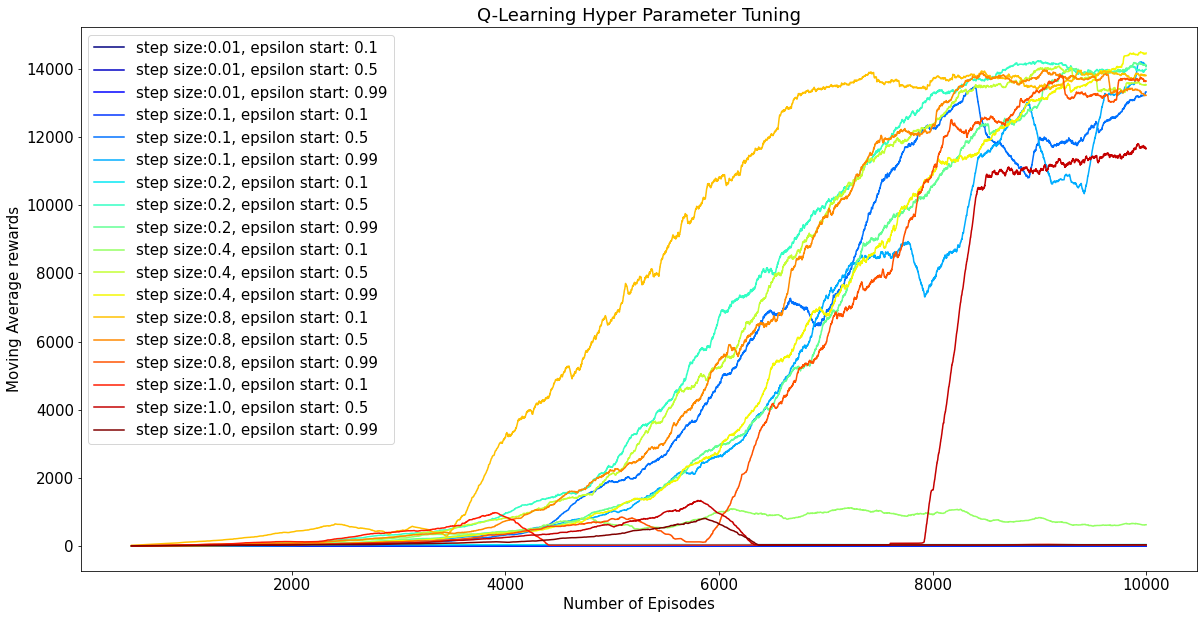

In [131]:
plot_FB_HP_score(QL_param_tuning,"rewards","Q-Learning",window = 100)

Whilst the pair of step step size = 0.8 and episilon start = 0.1 converges the fastest, we can notice the pair of step size = 0.4 and epsilon = 0.99 continues to grow in reward beyond the 10000 episode mark.

In [9]:
#Agent 2 - Expected SARSA Hyperparameter tuning
params = {"alpha": [0.01, 0.1, 0.2, 0.4, 0.8, 1.0], "eps_start": [0.1, 0.5, 0.99]}
QL_scores = {}
QL_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
for alpha in params['alpha']:
    for eps_start in params['eps_start']:
        i+=1
        _, scores_history, _,total_reward_history = train_agent(num_episodes = 10000, 
                                                                             max_score = 1500, eps_start = eps_start,
                                                                             eps_decay = 0.999, eps_min = 1e-4, 
                                                                             step_size = alpha, 
                                                                             gamma = 0.95,algorithm = 'ES')
        QL_scores[(alpha,eps_start)] = scores_history
        QL_rewards[alpha,eps_start] = total_reward_history
        print(f"{i}/{total_trials} trials completed!")
        

100%|██████████| 10000/10000 [00:05<00:00, 1669.85it/s]


1/18 trials completed!


100%|██████████| 10000/10000 [00:05<00:00, 1789.74it/s]


2/18 trials completed!


100%|██████████| 10000/10000 [00:05<00:00, 1699.35it/s]


3/18 trials completed!


100%|██████████| 10000/10000 [00:06<00:00, 1600.34it/s]


4/18 trials completed!


100%|██████████| 10000/10000 [05:12<00:00, 31.95it/s]


5/18 trials completed!


100%|██████████| 10000/10000 [31:40<00:00,  5.26it/s] 


6/18 trials completed!


100%|██████████| 10000/10000 [00:09<00:00, 1071.38it/s]


7/18 trials completed!


100%|██████████| 10000/10000 [55:40<00:00,  2.99it/s]


8/18 trials completed!


100%|██████████| 10000/10000 [38:43<00:00,  4.30it/s]


9/18 trials completed!


100%|██████████| 10000/10000 [04:14<00:00, 39.28it/s] 


10/18 trials completed!


100%|██████████| 10000/10000 [52:54<00:00,  3.15it/s]


11/18 trials completed!


100%|██████████| 10000/10000 [44:06<00:00,  3.78it/s]


12/18 trials completed!


100%|██████████| 10000/10000 [08:33<00:00, 19.49it/s]


13/18 trials completed!


100%|██████████| 10000/10000 [46:27<00:00,  3.59it/s]


14/18 trials completed!


100%|██████████| 10000/10000 [38:55<00:00,  4.28it/s] 


15/18 trials completed!


100%|██████████| 10000/10000 [54:51<00:00,  3.04it/s]  


16/18 trials completed!


100%|██████████| 10000/10000 [32:37<00:00,  5.11it/s]


17/18 trials completed!


100%|██████████| 10000/10000 [02:11<00:00, 76.03it/s]

18/18 trials completed!


In [10]:
#Save hyperparameter files
# f = open("ES"+"_scores_10000_gs_dict_1500_pipes.pkl","wb")
# # write the python object (dict) to pickle file
# pickle.dump(QL_scores,f)
# # close file
# f.close()

# f = open("ES"+"_rewards_10000_gs_dict_1500_pipes.pkl","wb")
# # write the python object (dict) to pickle file
# pickle.dump(QL_rewards,f)
# # close file
# f.close()

In [125]:
#Load Hyperparameter Files
with (open("ES_scores_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           ES_scores_10000 =  pickle.load(openfile)
        except EOFError:
            break
            
with (open("ES_rewards_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           ES_rewards_10000 =  pickle.load(openfile)
        except EOFError:
            break

In [126]:
ES_param_tuning = {"scores":ES_scores_10000,"rewards":ES_rewards_10000}

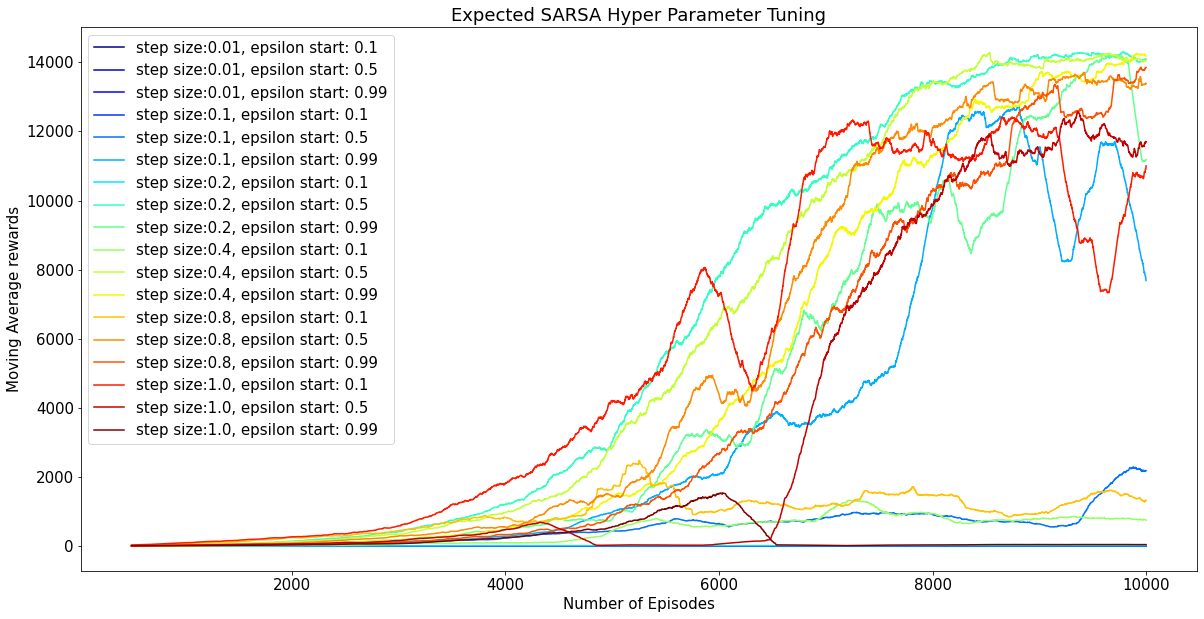

In [132]:
plot_FB_HP_score(ES_param_tuning,"rewards","Expected SARSA",window = 100)

The pair of step size = 0.2 and epsilon start = 0.5 converges the quickest to the highest reward

## Model Training on Optimal Parameters

In [28]:
optimal_params = {"QL": [0.4, 0.99], "ES": [0.5, 0.2]}

for algo in ['QL','ES']:
    
    epsilon = optimal_params[algo][0]
    alpha = optimal_params[algo][1]

    trained_agent, scores_history,total_reward_history = train_agent(num_episodes = 15000, 
                                                                             max_score = 7000, eps_start = epsilon,
                                                                             eps_decay = 0.999, eps_min = 1e-4, 
                                                                            step_size = alpha, gamma = 0.95,
                                                                            algorithm = algo)
  
    history_dict = {"scores": scores_history,"rewards": total_reward_history}

    # create a binary pickle file 
    f = open(algo+"_history_dict_3.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(history_dict,f)
    # close file
    f.close()
 
    # create a binary pickle file 
    f = open(algo+"_agent_model_3.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(trained_agent,f)
    # close file
    f.close()
    break

100%|██████████| 15000/15000 [3:12:15<00:00,  1.30it/s]  


In [16]:
with (open("QL_agent_model_3.pkl", "rb")) as openfile:
    while True:
        try:
           QL_agent =  pickle.load(openfile)
        except EOFError:
            break

with (open("QL_history_dict_3.pkl", "rb")) as openfile:
    while True:
        try:
           QL_history =  pickle.load(openfile)
        except EOFError:
            break
            
with (open("ES_agent_model_3.pkl", "rb")) as openfile:
    while True:
        try:
           ES_agent =  pickle.load(openfile)
        except EOFError:
            break

with (open("ES_history_dict_3.pkl", "rb")) as openfile:
    while True:
        try:
           ES_history =  pickle.load(openfile)
        except EOFError:
            break

## Model Comparison

Value Function Comparison

In [28]:
def plot_FB_values(agent,agent_name):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    def get_Z(x, y, agent):
        if (x,y) in agent.state_dict.keys():
            return np.max(agent.q[agent.state_dict[(x,y)]])
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 13)
        y_range = np.arange(-11, 12)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
        ax.set_xlabel('Player\'s X Distance from Pipe')
        ax.set_ylabel('Player\'s Y Distance from Pipe')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(agent_name + ' State Value Plot')
    get_figure(ax)


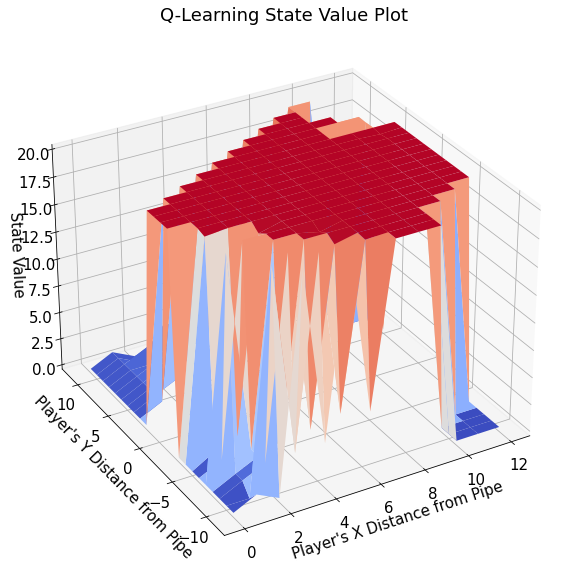

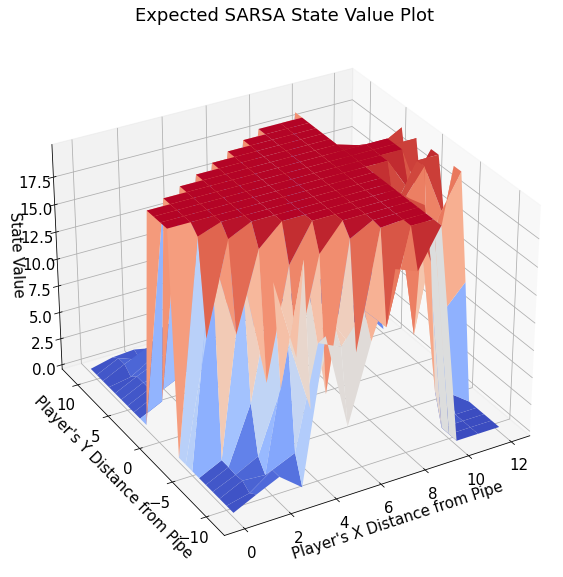

In [133]:
plot_FB_values(QL_agent, 'Q-Learning')
plot_FB_values(ES_agent, 'Expected SARSA')

In [89]:
def plot_FB_score(score_history, score_name,agent_name,window=100):
    assert score_name in score_history.keys()
    
    moving_average = []
    for i in range(len(score_history[score_name]) - window + 1):
         moving_average.append(np.mean(score_history[score_name][i:i+window]))
           
    plt.plot(moving_average);
    plt.title(f"{agent_name} {score_name} - {window} Moving Average");
    plt.xlabel('Number of Episodes')
    plt.ylabel(f"Moving Average {score_name}")
    plt.show()

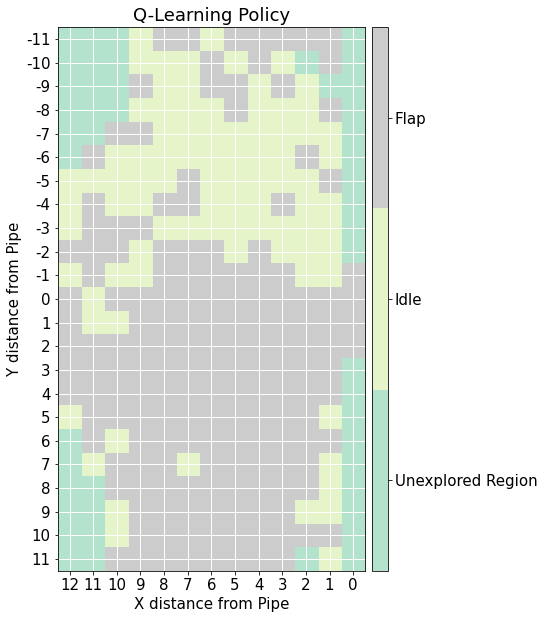

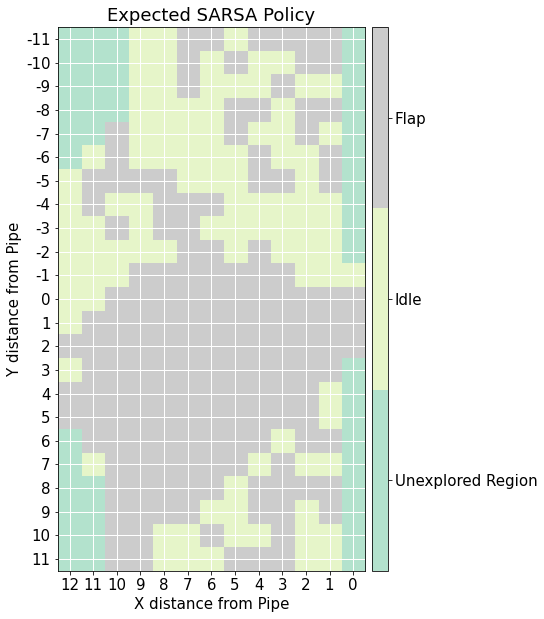

In [134]:
plot_policy(QL_agent,'Q-Learning')
plot_policy(ES_agent,'Expected SARSA')

**Scores is a good proxy of Rewards**

In [63]:
def plot_policy(agent,agent_name):
    
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    def get_Z_with_unexplored(x, y,agent):
        if (x,y) in agent.state_dict.keys():
            return np.argmax(agent.q[agent.state_dict[(x,y)]])
        else:
            return -1 #define a value for Z to visualize unexplored areas
    
    def get_figure(ax):
        x_range = np.arange(0, 13)
        y_range = np.arange(-12, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z_with_unexplored(x,y, agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape) 
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2'))
        plt.xticks(x_range) 
        plt.yticks(np.arange(23), range(-11, 12, 1)) 
        plt.gca().invert_xaxis() 
        ax.set_xlabel('X distance from Pipe') 
        ax.set_ylabel('Y distance from Pipe') 

        ax.grid(color='w', linestyle='-', linewidth=1) 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1) 
        cbar = plt.colorbar(surf, boundaries=[-1.5,-0.5,0.5,1.5], ticks=[-1,0,1], cax=cax) 
        cbar.ax.set_yticklabels(['Unexplored Region', 'Idle','Flap']

    
    fig = plt.figure(figsize=(10, 10)) 
    ax = fig.add_subplot(111)
    ax.set_title(agent_name + ' Policy')
    get_figure(ax)
    plt.show() # show the plot

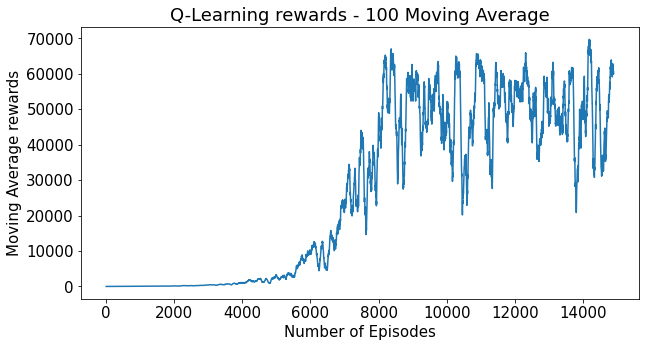

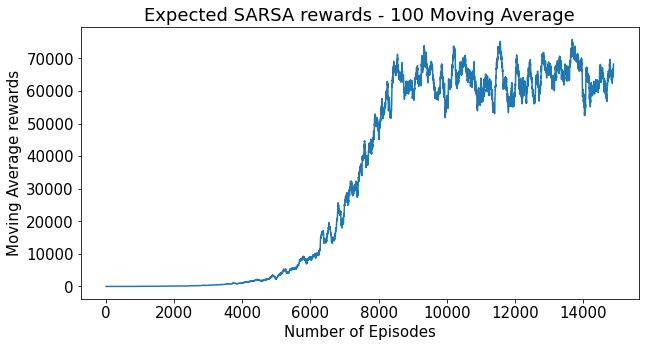

In [93]:
plot_FB_score(QL_history,'rewards','Q-Learning')
plot_FB_score(ES_history,'rewards','Expected SARSA')

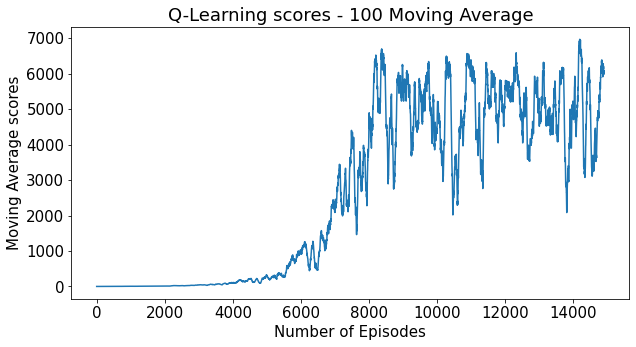

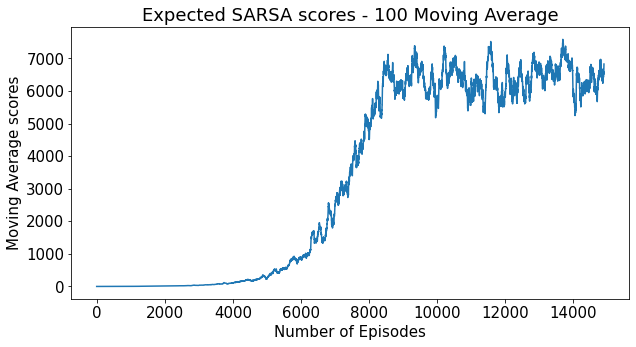

In [94]:
plot_FB_score(QL_history,'scores','Q-Learning')
plot_FB_score(ES_history,'scores','Expected SARSA')

## Simulation of on both agent TextFlappyBird-v0

The game rendering has been supressed for faster computation.

In [163]:
def get_Z_with_unexplored(x, y,agent):
    if (x,y) in agent.state_dict.keys():
        return np.argmax(agent.q[agent.state_dict[(x,y)]])
    else:
        return -1 #define a value for Z to visualize unexplored areas
def play_game(max_score = 1e3):
    
    for player in [(QL_agent,"Q-Learning"),(ES_agent,"Expected SARSA")]:
        obs = env.reset()
        obs = obs[0]
        while True:
            obs, reward, done, _, info = env.step(get_Z_with_unexplored(obs[0],obs[1],player[0]))


          # Render the game
        #   os.system("clear")
        #   sys.stdout.write(env.render())
        #   time.sleep(0.2) # FPS

          # If player is dead break
            if (done) | (info['score'] > int(max_score)):
                if (info['score'] > int(max_score)):
                    print(f"{player[1]} Player has reached the Max Score of {int(max_score)}!")
                else:          
                    print(f"{player[1]} Player Score: info['score'] - Did not reach Max set score of {int(max_score)} :(")
                break


        env.close()

In [167]:
#Simulation of Game up to a score of 1 million (so that we force the bird stop flapping!)
play_game(1e6)

Q-Learning Player has reached the Max Score of 1000000!
Expected SARSA Player has reached the Max Score of 1000000!


## Attempt at Flappy Bird Screen

In [408]:
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)


/Users/kh/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 15)
  logger.warn(


In [411]:
def get_Z_with_sampling(x, y,agent,environment):
    if (x,y) in agent.state_dict.keys():
        return np.argmax(agent.q[agent.state_dict[(x,y)]])
    else:
        return -1
    
obs,bird = env.reset()
bird = bird['player']

while True:


    next_pipe_x = min([x for x in np.where(obs == 2)[0] if  x >= bird[0]])
    # print(next_pipe_x)
    next_pipe_y = list(reversed(obs[next_pipe_x,:]))
    next_pipe_y = [i for i,y in enumerate(next_pipe_y) if y == 0][1]
    next_pipe = (next_pipe_x,next_pipe_y)
    print(next_pipe)
    distance_from_pipe = (next_pipe[0] - bird[0], next_pipe[1] - bird[1])
    # print(distance_from_pipe)
    state = distance_from_pipe
#     state = obs
    print(state)
    action = 1 - get_Z_with_sampling(state[0],state[1],QL_agent,env)
    print("Env Stepped")
    # Apply action and return new observation of the environment
    obs, reward, done, _, bird = env.step(action)
    print(action)
    bird = bird['player']
    print(obs.T)
    print(bird)

    if state in ES_agent.state_dict.keys():
        print("Exists")
    else:
        print("Not Exists")

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

    # If player reaches a score of 2000
    if info['score'] == 2000:
        break

env.close()

(19, 7)
(13, 0)
Env Stepped
1
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]]
[6, 6]
Exists
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[      

In [3]:
import time
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")

obs = env.reset()
print(env.step(1))
print(obs)
# while True:
#     # Next action:
#     # (feed the observation to your agent here)
#     action = ...  # env.action_space.sample() for a random action

#     # Processing:
#     obs, reward, done, info = env.step(action)
    
#     # Rendering the game:
#     # (remove this two lines during training)
#     env.render()
#     time.sleep(1 / 30)  # FPS
    
#     # Checking if the player is still alive
#     if done:
#         break

# env.close()

(array([1.64236111, 0.02539062]), 1, False, {'score': 0})
[1.65625   0.0078125]


/Users/kh/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:235: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/kh/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:157: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/kh/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
